In [4]:
import numpy as np
import sklearn.utils.extmath as sm
from numpy.linalg import inv
from numpy.linalg import eig
from numpy import dot, diag
from scipy.linalg import sqrtm
from scipy.spatial.distance import euclidean
import pandas as pd
import random, math
np.random.seed(42)
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Extension of the cluster kernel

## Functions for the main algorithm of the paper


In [14]:
def fill_diag(M, a):
    """
    M: square matrix
    a: array of length number of rows
    ----
    fill the diagonal of M with values of array a
    """
    s = M.shape
    D = np.zeros(s)
    for i in range(s[0]):
        D[i,i] = a[i]
    return D
# let A be a matrix, A.T is the transpose of A
def rbf_kernel(X, Y, sigma):
    K = np.zeros((len(X), len(X)))
    for a in range(len(X)):
        for b in range(len(X)):
            K[a, b] = rbf_function(X[a], X[b])
    return K
            
def rbf_function(x, y, sigma=1):
    exponent = - (euclidean(x, y)**2) / (2*(sigma**2))
    return np.exp(exponent)


def diagonal_row_sum_matrix(M):
    rows_sum = M.sum(axis=1)
    return fill_diag(M,rows_sum)

def computeL(D,K):
    Dinv = inv(D)
    return sqrtm(Dinv).dot(K).dot(sqrtm(Dinv))

def build_K(lambdaCut, transfer, X, Y=None, sigma=None):
    
    #Step 1 - K matrix
    K = rbf_kernel(X, Y, sigma)
    D = diagonal_row_sum_matrix(K)
    
    #Step 2 - L matrix
    L = computeL(D, K)
    eigen_vals, U = eig(L)
    Q = diag(eigen_vals)
    
    #Step 3 - Transfer Function
    newEigen = transfer(eigen_vals, lambdaCut)
    newEigen = diag(newEigen)
    
    #Step 4 - New Kernel matrix
    newL = U.dot(newEigen).dot(U.T)
    newD = inv(diag(diag(L)))
    newK = sqrtm(newD).dot(newL).dot(sqrtm(newD))
    return newK
    

#TRANSFER FUNCTION
def linear(vals, lambdaCut):
    return vals

def step(vals,lambdaCut):
    return [ 1 if x >= lambdaCut else 0 for x in vals ]

def linear_step(vals, lambdaCut):
    return [ x if x >= lambdaCut else 0 for x in vals ]

def polynomial(vals, exponent):
    return [ np.power(x, exponent) for x in vals ]



## SVM functions

In [6]:
### Kernels
def linear_kernel(x1, x2, p):
    return np.dot(x1, x2)+1;

def polyn_kernel(x1, x2, p):
    return (np.dot(x1, x2)+1)**p

def rbf_kernel(x1, x2, sigma):
    return np.exp(-((np.linalg.norm(x1-x2)**2)/(2*(sigma**2))))



### Global Matrix -> should be used as global variable later, as it is called numerous times.
def compute_global_matrix(x, y, kernel, p_or_sigma=0):
    N = x.shape[0]
    kernel = kernel
    glob_matrix = [];
    
    for i in range(0, N):
        temp = []
        for j in range(0, N):
            result = y[i] * y[j] * kernel(x[i], x[j], p_or_sigma)
            temp.append(result)
        glob_matrix.append(temp)
    
    return np.array(glob_matrix);


### Optimising Function
def objective_function(alpha):
    obj_value = 0
    alphas = 0
    
    for i in range(0, len(global_matrix)):
        for j in range(0, len(global_matrix)):
            obj_value += alpha[i] * alpha[j] * global_matrix[i][j]
        alphas += alpha[i]
    obj_value *= 0.5
    obj_value -= alphas
    
    return obj_value
        

### Zerofun -> This function must be equal to 0
def zerofun(alphas):
    return np.dot(alphas, targets)    


### Minimise Function
def compute_alphas(slack, N):
    alphas = np.zeros(N);
    bound = [(0, slack) for l in range(N)]
    xc = {'type': 'eq', 'fun': zerofun}
    minimi = minimize(objective_function, alphas, bounds = bound, constraints = xc )
    alphas = minimi["x"]
    alphas = [0 if x<0.00001 else x for x in alphas]
    
    return alphas


### Return Non-Zeros Alphas
def return_nonzeros(alphas, inputs, targets, slack):
    non_zeros_indices = []
    non_zeros_alphas = []
    non_zeros_inputs = []
    non_zeros_targets = []
    
    N = inputs.shape[0]

    for i in range(0, N):
        if (alphas[i] > 0.00001 and alphas[i] <= slack):
            non_zeros_indices.append(i)
            non_zeros_alphas.append(alphas[i])
            non_zeros_inputs.append(inputs[i])
            non_zeros_targets.append(targets[i])
    return non_zeros_indices, non_zeros_alphas, non_zeros_inputs, non_zeros_targets


### Get support vector 
def get_b(alphas, non_zeros_indices, inputs, targets, kernel, p_or_sigma = 0):
    b=[]
    bb = 0
    
    for i in non_zeros_indices:
        bb = 0
        for j in range(0, len(inputs)):
            bb += alphas[j] * targets[j] * kernel(inputs[i], inputs[j], p_or_sigma)
        bb -= targets[i]
        b.append(bb)  
    
    return np.mean(b)


### Classification function
def indicator(to_be_classified, non_zeros_alphas, non_zeros_targets, non_zeros_inputs, b, kernel, slack, p_or_sigma = 0):
    value = 0;
    
    for i in range(0, len(non_zeros_alphas)):
        value += non_zeros_alphas[i] * non_zeros_targets[i] * kernel(to_be_classified, non_zeros_inputs[i], p_or_sigma)
        value -= b
    
    return value;


def train(x, y, kernel, slack, p_or_sigma = 0):
    
    alphas = compute_alphas(slack, x.shape[0])
    non_zeros_indices, non_zeros_alphas, non_zeros_inputs, non_zeros_targets = return_nonzeros(alphas, x, y, slack)
    b = get_b(alphas, non_zeros_indices, x, y, kernel, p_or_sigma)
    
    return non_zeros_alphas, non_zeros_targets, non_zeros_inputs, b

def test(test_points, non_zeros_alphas, non_zeros_targets, non_zeros_inputs, b, kernel, slack, p_or_sigma = 0):
    
    predictions = []
    for point in test_points:
        test_target = indicator(point, non_zeros_alphas, non_zeros_targets, non_zeros_inputs, b, kernel, slack, p_or_sigma)
        predictions.append(test_target)
    return predictions
    
    
    
    
    



In [7]:
test_x = np.array([[1 ,3], [2, 3], [1, 2], [1.5, 1], [3, 1.5], [2, 1.5], [7, 9], [8, 7], [8, 9], [7.5, 8], [9, 7.5]])
targets = np.array([-1., -1., -1., -1., -1., -1., 1., 1., 1., 1., 1.])
global_matrix = compute_global_matrix(test_x, targets, linear_kernel, 0)

In [8]:
non_zeros_alphas, non_zeros_targets, non_zeros_inputs, b = train(test_x, targets, linear_kernel, 1000, 0)

In [9]:
testtest_x = np.array([[1.5, 1.5], [8, 8]])
predictions = test(testtest_x, non_zeros_alphas, non_zeros_targets, non_zeros_inputs, b, linear_kernel, 1000, 0)


In [10]:
def plot_it_all(classA, classB, non_zero_alphas, non_zero_inputs, non_zero_targets, b, title, kernel, slack, p_or_sigma):
    plt.plot([p[0] for p in classA],
            [p[1] for p in classA],
            'b.')
    plt.plot([p[0] for p in classB],
            [p[1] for p in classB],
            'r.')
    plt.axis("equal")
    plt.savefig(title)
    xgrid = np.linspace(-5, 5)
    ygrid = np.linspace(-4, 4)
    grid = np.array([[indicator([x, y], non_zeros_alphas, non_zeros_targets, non_zeros_inputs, b, kernel, slack, p_or_sigma)
                     for x in xgrid]
                     for y in ygrid])
    plt.contour(xgrid, ygrid, grid,
               (-1.0, 0.0, 1.0),
                colors = ("red", "black", "blue"),
                linewidths = (1,3,1))
    plt.plot([p[0] for p in classA],\
              [p[1] for p in classA],\
              'b.')
    
    plt.plot([p[0] for p in classB],\
              [p[1] for p in classB],\
              'r.')
    plt.axis("equal")
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


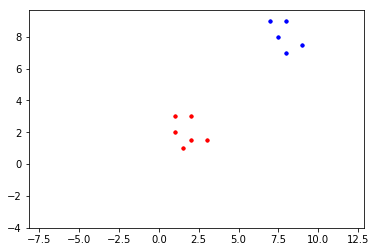

In [11]:
plot_it_all(test_x[6:], test_x[0:6], non_zeros_alphas, non_zeros_inputs, non_zeros_targets, b, "", linear_kernel, 1000, 0)

## Main


### Dummy example

In [15]:
nb_samples = 4 #nb of samples
dim_sample = 5
X = np.random.rand(nb_samples,dim_sample)
lambdaCut = 1

K = build_K(lambdaCut, linear, X)


In [16]:
K

array([[1.        , 0.85990169, 0.72197121, 0.90257394],
       [0.85990169, 1.        , 0.54713097, 0.84008359],
       [0.72197121, 0.54713097, 1.        , 0.81645966],
       [0.90257394, 0.84008359, 0.81645966, 1.        ]])

## Datasets

In [139]:
import pickle
from numpy.core import multiarray
import pandas as pd

### Digit Datasets

In [185]:
with open("../Dataset/digitDataset.pickle", "rb") as fp:
    digits = pickle.load(fp,encoding='bytes')

In [181]:
X = []
labels = []
for i in range(0, len(digits)):
    X.append(digits[i][0])
    labels.append(digits[i][1])
X = np.array(X)
labels = np.array(labels)

In [182]:
lambdaCut = 1

K = build_K(lambdaCut, step, X)

### Text Datasets

In [222]:
with open("../Dataset/textDataset.pickle", "rb") as fp:
    text = pickle.load(fp, encoding="latin-1")


In [223]:
text[0][0].shape


(1, 33967)

#### Experiments procedure // TODO

- Test set:  
    987 points 
- Labeled sets:
    100 different ones containing 2 to 128 labelled points
    randomly selected
- compared kernels : 
    - linear
    - polynomial
    - step
    - poly-step
- Try svms   